In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from configparser import ConfigParser
from sqlalchemy import create_engine

# View Dataset

In [36]:
! pip freeze > requirements.txt

In [2]:
RETRIEVE = 0
INSERT = 1

def load_dbconfig(filename='config.ini', section='warehouse'):
    parser = ConfigParser()
    parser.read(filename)
    dbconfig = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            dbconfig[param[0]] = param[1]
    else:
        raise Exception('Section {} not found in the {} file'.format(section, filename))
    return dbconfig

def execute_sql(dbconfig, sql, method=None, param=None):
    try:
        engine = create_engine(dbconfig['service_url'])
        if method == RETRIEVE:
            return pd.read_sql(sql, engine, params=param)
        else:
            with engine.connect() as conn:
                conn.execute(sql, param) if param else conn.execute(sql)
    except Exception as error:
        print(error)

In [3]:
dbconfig = load_dbconfig()

get_state_fact = "SELECT * FROM state_province_fact"
df_state = execute_sql(dbconfig, get_state_fact, method=RETRIEVE)

get_date_dim = "SELECT * FROM date_dim"
df_date = execute_sql(dbconfig, get_date_dim, method=RETRIEVE)
# df_state = pd.read_csv("transformed_tables/StateProvinceFact.csv")
# df_date = pd.read_csv("transformed_tables/DateDim.csv")

In [13]:
df_state.head()

,date_id,state_province_id,state_province_code,state_province_name,country_region_name,province_lat,province_long,product_count,order_count,total_discount,customer_count,total_sale
0,20110701,1,AB,Alberta,Canada,55.001251,-115.002136,75,4,0.000000,4,92126.911000
1,20111001,1,AB,Alberta,Canada,55.001251,-115.002136,92,4,469.798608,4,111081.906592
2,20111118,1,AB,Alberta,Canada,55.001251,-115.002136,1,1,0.000000,1,3578.270000
3,20120101,1,AB,Alberta,Canada,55.001251,-115.002136,65,3,0.000000,3,68109.907700
4,20120330,1,AB,Alberta,Canada,55.001251,-115.002136,78,4,0.000000,4,84921.048300


In [14]:
df_date.head()

,date_id,full_date,day,month,quarter,year,is_weekday,day_of_week
0,20110531,2011-05-31,31,5,2,2011,True,Tuesday
1,20110601,2011-06-01,1,6,2,2011,True,Wednesday
2,20110602,2011-06-02,2,6,2,2011,True,Thursday
3,20110603,2011-06-03,3,6,2,2011,True,Friday
4,20110604,2011-06-04,4,6,2,2011,False,Saturday


In [6]:
df_state.describe()

,date_id,state_province_id,province_lat,province_long,product_count,order_count,total_discount,customer_count,total_sale
count,1.103200e+04,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000
mean,2.012935e+07,65.022117,27.153055,1.727906,24.689630,2.823241,47.580163,2.817984,9857.899512
std,9.061226e+03,52.455971,34.228013,95.614088,95.143648,3.176655,666.300106,3.168929,33366.006918
min,2.011053e+07,1.000000,-42.035067,-125.002441,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.012100e+07,15.000000,27.756767,-82.688140,1.000000,1.000000,0.000000,1.000000,817.085000
50%,2.013081e+07,58.000000,43.979280,2.239292,3.000000,1.000000,0.000000,1.000000,2443.350000
75%,2.014012e+07,79.000000,50.528967,13.246130,11.000000,3.000000,0.000000,3.000000,4701.140000
max,2.014063e+07,181.000000,55.001251,147.286949,2127.000000,35.000000,40571.442625,35.000000,679929.180407


In [7]:
df_date.describe()

,date_id,day,month,quarter,year
count,1.139000e+03,1139.000000,1139.000000,1139.000000,1139.000000
mean,2.012537e+07,15.642669,6.511853,2.499561,2012.470588
std,9.691977e+03,8.820589,3.386444,1.100707,0.983057
min,2.011053e+07,1.000000,1.000000,1.000000,2011.000000
25%,2.012031e+07,8.000000,4.000000,2.000000,2012.000000
50%,2.012122e+07,16.000000,6.000000,2.000000,2012.000000
75%,2.013097e+07,23.000000,9.000000,3.000000,2013.000000
max,2.014071e+07,31.000000,12.000000,4.000000,2014.000000


In [4]:
df = pd.merge(df_state, df_date, on='date_id', how='inner')
df.head()

,date_id,state_province_id,state_province_code,state_province_name,country_region_name,province_lat,province_long,product_count,order_count,total_discount,customer_count,total_sale,full_date,day,month,quarter,year,is_weekday,day_of_week
0,20110701,1,AB,Alberta,Canada,55.001251,-115.002136,75,4,0.0,4,92126.9110,2011-07-01,1,7,3,2011,True,Friday
1,20110701,7,BC,British Columbia,Canada,55.001251,-125.002441,58,5,0.0,5,26039.1562,2011-07-01,1,7,3,2011,True,Friday
2,20110701,9,CA,California,United States,36.701463,-118.755997,314,10,0.0,10,202442.9449,2011-07-01,1,7,3,2011,True,Friday
3,20110701,10,CO,Colorado,United States,38.725178,-105.607716,68,2,0.0,2,48849.6856,2011-07-01,1,7,3,2011,True,Friday
4,20110701,11,CT,Connecticut,United States,41.650020,-72.734216,32,1,0.0,1,18320.6894,2011-07-01,1,7,3,2011,True,Friday


# GroupByStateLatLngWithTotalSale 

In [32]:
df

,date_id,state_province_id,state_province_code,state_province_name,country_region_name,province_lat,province_long,product_count,order_count,total_discount,customer_count,total_sale,full_date,day,month,quarter,year,is_weekday,day_of_week
0,20110701,1,AB,Alberta,Canada,55.001251,-115.002136,75,4,0.0,4,92126.9110,2011-07-01,1,7,3,2011,True,Friday
1,20110701,7,BC,British Columbia,Canada,55.001251,-125.002441,58,5,0.0,5,26039.1562,2011-07-01,1,7,3,2011,True,Friday
2,20110701,9,CA,California,United States,36.701463,-118.755997,314,10,0.0,10,202442.9449,2011-07-01,1,7,3,2011,True,Friday
3,20110701,10,CO,Colorado,United States,38.725178,-105.607716,68,2,0.0,2,48849.6856,2011-07-01,1,7,3,2011,True,Friday
4,20110701,11,CT,Connecticut,United States,41.650020,-72.734216,32,1,0.0,1,18320.6894,2011-07-01,1,7,3,2011,True,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11027,20110717,71,TAS,Tasmania,Australia,-42.035067,146.636689,1,1,0.0,1,3578.2700,2011-07-17,17,7,3,2011,False,Sunday
11028,20110617,77,VIC,Victoria,Australia,-36.598610,144.678005,2,2,0.0,2,6953.2600,2011-06-17,17,6,2,2011,True,Friday
11029,20110903,77,VIC,Victoria,Australia,-36.598610,144.678005,1,1,0.0,1,3578.2700,2011-09-03,3,9,3,2011,False,Saturday
11030,20110903,79,WA,Washington,United States,38.895037,-77.036543,1,1,0.0,1,3578.2700,2011-09-03,3,9,3,2011,False,Saturday


In [23]:
weight_attr = "average_order_sale" #specifying the attribute that should be used as weight 
country_names = ["United States", "Canada", "United Kingdom"] 
dims = ["province_lat", "province_long", weight_attr]
# Dynamic filtering using the list of country names
df_stateonly = df[df["country_region_name"].isin(country_names)].groupby(['state_province_id', 'state_province_code', 'state_province_name', 'country_region_name', 'province_lat', 'province_long'])[["total_sale", "product_count","order_count","total_discount"]].sum()
df_stateonly = df_stateonly.reset_index()
df_stateonly['average_order_sale'] = df_stateonly['total_sale'] / df_stateonly['product_count']
cls_df = df_stateonly[dims]
cls_df

,province_lat,province_long,average_order_sale
0,33.258882,-86.829534,510.857517
1,34.395342,-111.763275,346.855916
2,36.701463,-118.755997,421.257315
3,38.725178,-105.607716,357.439034
4,41.650020,-72.734216,473.316338
5,27.756767,-81.463983,375.393265
6,32.329381,-83.113737,401.164385
7,43.644764,-114.015407,488.820969
8,40.079661,-89.433729,400.503645
9,40.327013,-86.174693,370.022584


In [24]:
scaler = MinMaxScaler()
X = scaler.fit_transform(cls_df.iloc[:,0:2])
weight = cls_df.iloc[:,2].values

e:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


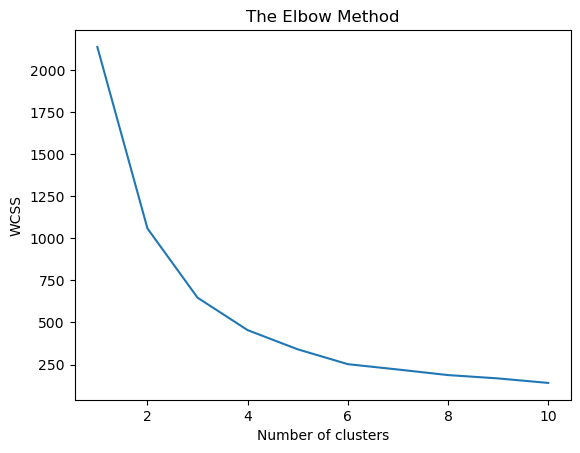

In [25]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X,sample_weight=weight)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

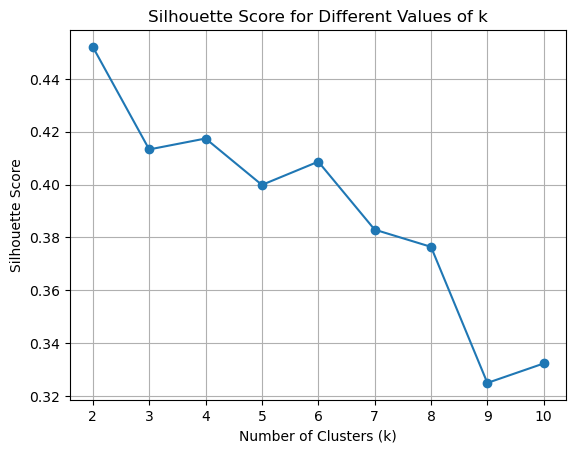

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)

silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    labels = kmeans.fit_predict(X,sample_weight=weight)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.xticks(np.arange(min(k_values), max(k_values)+1, 1.0))
plt.grid(True)
plt.show()


In [27]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
wt_kmeansclus = kmeans.fit(X,sample_weight=weight)
labels = kmeans.predict(X,sample_weight=weight)
centroids = kmeans.cluster_centers_.reshape(-1, 2)


In [28]:
centroids 

array([[0.3278237 , 0.67042018],
       [0.728998  , 0.78018109],
       [0.68247449, 0.18961644]])

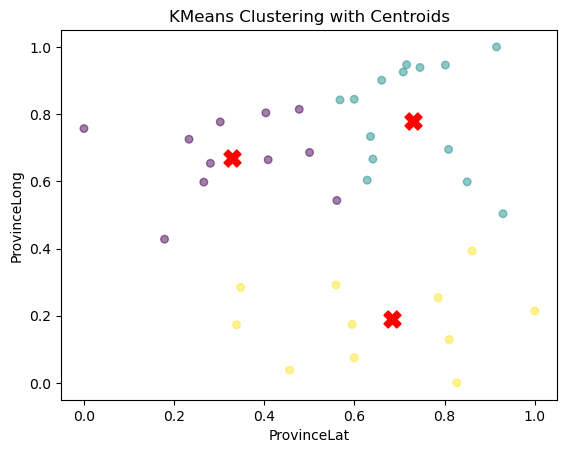

In [29]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap= 'viridis', s=30, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=150)
plt.xlabel('ProvinceLat')
plt.ylabel('ProvinceLong')  # Hide y-axis
plt.title('KMeans Clustering with Centroids')
plt.show()

In [30]:
df_stateonly['labels'] = labels
df_stateonly

,state_province_id,state_province_code,state_province_name,country_region_name,province_lat,province_long,total_sale,product_count,order_count,total_discount,average_order_sale,labels
0,3,AL,Alabama,United States,33.258882,-86.829534,4.546632e+04,89,22,0.000000,510.857517,0
1,6,AZ,Arizona,United States,34.395342,-111.763275,1.330886e+06,3837,65,13293.822065,346.855916,2
2,9,CA,California,United States,36.701463,-118.755997,1.519939e+07,36081,5830,94150.989180,421.257315,2
3,10,CO,Colorado,United States,38.725178,-105.607716,2.395914e+06,6703,64,8142.005151,357.439034,2
4,11,CT,Connecticut,United States,41.650020,-72.734216,1.088628e+06,2300,57,2192.359807,473.316338,1
5,15,FL,Florida,United States,27.756767,-81.463983,2.295154e+06,6114,157,12594.760168,375.393265,0
6,17,GA,Georgia,United States,32.329381,-83.113737,1.046237e+06,2608,76,3035.648565,401.164385,0
7,23,ID,Idaho,United States,43.644764,-114.015407,2.273018e+05,465,13,2647.612350,488.820969,2
8,24,IL,Illinois,United States,40.079661,-89.433729,6.107681e+05,1525,73,412.456839,400.503645,1
9,25,IN,Indiana,United States,40.327013,-86.174693,1.050124e+06,2838,64,965.594963,370.022584,1


In [35]:
# Function for map displaying
import folium

zooming = 30 # In case of using normalization, the numbers will be pretty small; therefore, we should multiply
             # the normalized figures with a number for enlarging it 
def normalize_sizes(sizes):
    min_size = min(sizes)
    max_size = max(sizes)
    normalized_sizes = [(size - min_size) / (max_size - min_size) for size in sizes]
    return normalized_sizes 

# Sample data: latitude, longitude, size, and labels of each point
sizes = normalize_sizes(df_stateonly[weight_attr])
latitude = df_stateonly['province_lat']
longitude = df_stateonly['province_long']
labels = df_stateonly['labels']
product_count = df_stateonly["product_count"]
average_order_sale = df_stateonly["average_order_sale"]

# Create a Folium Map centered at an initial location
m = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=4)

# Define colors for each label
label_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot points on the map with different colors based on labels
for lat, lon, size, label,product_count, average_order_sale in zip(latitude, longitude, sizes, labels, product_count, average_order_sale):
    popup_text = f"Product Count: {product_count}<br>Average Sale: {average_order_sale}"
    folium.CircleMarker(location=[lat, lon], radius=size * zooming, color=label_colors[label], fill=True, fill_color=label_colors[label], fill_opacity=0.6, popup=popup_text).add_to(m)

cluster_centers = scaler.inverse_transform(centroids)

# Plot cluster centers as markers
for center in cluster_centers:
    folium.Marker(location=center, icon=folium.Icon(color='red', icon='star')).add_to(m)

# Display the map
m


# Customize Distance Formula
In this part, we will try Haversine Distance instead of Euclidian Distance, since Haversine is more accurate when it comes to spherical dimension

In [26]:
from haversine import haversine
import scipy.spatial


def distance(p1,p2):
  return haversine(p1[1:], p2[1:])

def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,[0]])),axis=0))
  return results

def kmeans(data, k=None, centroids=None, steps=30):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)].reshape(-1,3)
  elbow = []
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: (distance(u,v)**2))
    elbow.append(sqdists)

    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  
  return clusters, centroids,elbow

In [27]:
X = cls_df[['product_count','province_lat','province_long']].values
cluster_new, centroid_new, elbow = kmeans(X,k=3)

In [28]:
df_stateonly['labels'] = cluster_new

In [29]:
# Function for map displaying
import folium

# Sample data: latitude, longitude, size, and labels of each point
latitude = df_stateonly['province_lat']
longitude = df_stateonly['province_long']
sizes = df_stateonly['average_order_sale']
labels = df_stateonly['labels']

# Create a Folium Map centered at an initial location
m = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=4)

# Define colors for each label
label_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot points on the map with different colors based on labels
for lat, lon, size, label in zip(latitude, longitude, sizes, labels):
    folium.CircleMarker(location=[lat, lon], radius=size / 100, color=label_colors[label], fill=True, fill_color=label_colors[label], fill_opacity=0.6, popup=label).add_to(m)

cluster_centers = scaler.inverse_transform(centroids)

# Plot cluster centers as markers
for center in cluster_centers:
    folium.Marker(location=center, icon=folium.Icon(color='red', icon='star')).add_to(m)

# Display the map
m
